**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```

# Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

# Import Clean Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 1.271 seconds


# List of parameters

In [4]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

# Create Train, validation and test datasets

In [5]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


In [6]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])  # [Batch Size, H, W; C], first image, the first two pixels , of the very first channel
print("\nSample of y_train:", batch_y_train[0:5])  # the first 5 values form the vector
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))  # reflects the balance of our target

(64, 128, 128, 3) (64, 3)

Sample of x_train: tf.Tensor(
[[ 99.26709   99.308105]
 [107.84375  138.55054 ]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


# Augmentation

In [7]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")
# maybe we can explore different factors

In [8]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=4, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

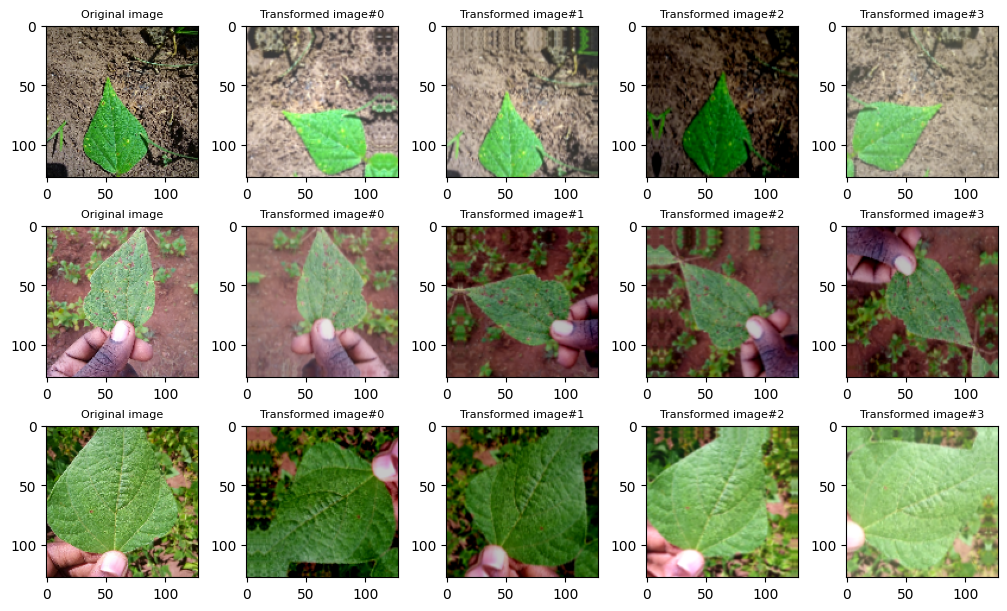

In [9]:
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=augmentation)

# Architectures

In [10]:
input_shape = tuple(batch_x_train.shape)
input_shape

(64, 128, 128, 3)

In [11]:
input_shape[1:]

(128, 128, 3)

## CNN 1 - LeNet

In this architecture, we start with an input image. Then we apply a feature map(filter) with a kernel size (5,5) (we can try (7,7) or (3,3)) and an initializer GlorotNormal ().
We apply an activation function of softmax used to multi-class classification models. 
The image becomes ready for the pooling step, providing our convolutional neural network the extraction of the maximum value to account for distortion, providing the faculty of spatial invariance.
We repeat this process twice.
Then we flatten to get a pooled featured map that will be the input for our ANN.
This way, we apply the classification with three units, the dimensionality of our output space, with the softmax activation function. After defining our model, we configure how to conduct the learning process through the compile function. Our main parameters are a categorical cross-entropy for our loss function, an SGD(Stochastic Gradient Descent) with a learning rate of 0.001.
We will iterate the process 40 times using our training and validation dataset.

### CNN1.1

Model: "CNN-V1_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 18)      1368      
                                                                 
 activation (Activation)     (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 58, 58, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 48)       0         
 2D)                                                      

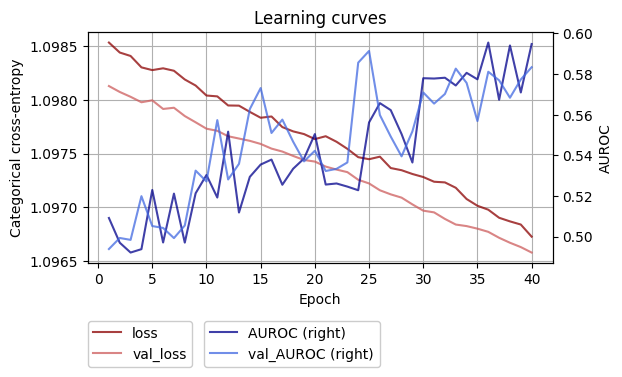

In [12]:
# Architecture V1.1
cnn1_1 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_1")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_1.build(input_shape)
# Check network
cnn1_1.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 40
history1_1 = cnn1_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

We need about 40 epoch to start to get more stable results, but even very instable. 

### CNN1.2
We will improve out basic model, with normalization, layers.Rescaling(1./255), similar to minmax, minimum value as 0 and maximum as 1, before we start the convolution process

Epoch 1/40
17/17 [==============================] - 6s 232ms/step - loss: 1.0989 - categorical_accuracy: 0.3298 - AUROC: 0.4973 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 2/40
17/17 [==============================] - 3s 101ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4794 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 3/40
17/17 [==============================] - 3s 125ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4866 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4981
Epoch 4/40
17/17 [==============================] - 5s 180ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4953 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 5/40
17/17 [==============================] - 5s 171ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4981 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AURO

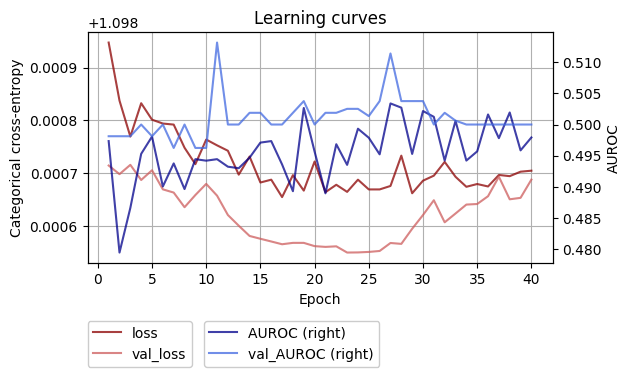

In [13]:
# Architecture V1.2
cnn1_2 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V2)
epochs = 40
history1_2 = cnn1_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.3
Add normalization does not improve the model. The performance could be better, and it is precarious. Therefore, we will add the augmentation we prepared previously. 

Epoch 1/40
17/17 [==============================] - 5s 110ms/step - loss: 1.0989 - categorical_accuracy: 0.3298 - AUROC: 0.4973 - val_loss: 1.0988 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 2/40
17/17 [==============================] - 3s 105ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4942 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 3/40
17/17 [==============================] - 7s 174ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4943 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 4/40
17/17 [==============================] - 3s 122ms/step - loss: 1.0988 - categorical_accuracy: 0.3298 - AUROC: 0.4941 - val_loss: 1.0986 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 5/40
17/17 [==============================] - 3s 105ms/step - loss: 1.0987 - categorical_accuracy: 0.3308 - AUROC: 0.5000 - val_loss: 1.0987 - val_categorical_accuracy: 0.3308 - val_AURO

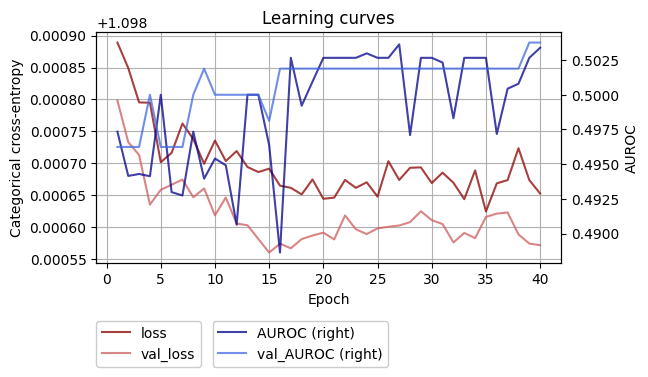

In [14]:
# Architecture V1.3
cnn1_3 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                    # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V3)
epochs = 40
history1_3 = cnn1_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

tf.get_logger().setLevel('ERROR')

### CNN1.4
As better results came from the first version, we will change the optimizer RMSprop to see if it improves

Epoch 1/40
17/17 [==============================] - 10s 206ms/step - loss: 1.3118 - categorical_accuracy: 0.3124 - AUROC: 0.4831 - val_loss: 1.4467 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 2/40
17/17 [==============================] - 3s 105ms/step - loss: 1.1801 - categorical_accuracy: 0.3356 - AUROC: 0.4996 - val_loss: 1.1366 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5038
Epoch 3/40
17/17 [==============================] - 3s 109ms/step - loss: 1.1780 - categorical_accuracy: 0.3559 - AUROC: 0.5095 - val_loss: 1.2301 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5038
Epoch 4/40
17/17 [==============================] - 4s 123ms/step - loss: 1.2200 - categorical_accuracy: 0.3095 - AUROC: 0.4790 - val_loss: 1.3619 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5025
Epoch 5/40
17/17 [==============================] - 3s 120ms/step - loss: 1.2033 - categorical_accuracy: 0.3317 - AUROC: 0.5058 - val_loss: 1.3206 - val_categorical_accuracy: 0.3308 - val_AUR

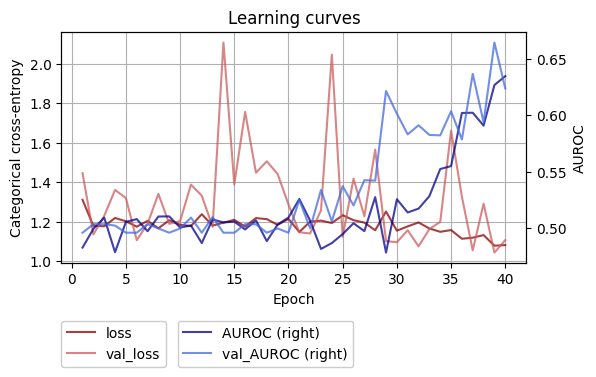

In [15]:
# Architecture V1.4
cnn1_4 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_4")


# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 40
history1_4 = cnn1_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN1.5
As better results came from the first version, we will change the optimizer to Adam and see if it improves

Epoch 1/40
17/17 [==============================] - 13s 202ms/step - loss: 1.1488 - categorical_accuracy: 0.3375 - AUROC: 0.5162 - val_loss: 1.1055 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 2/40
17/17 [==============================] - 6s 212ms/step - loss: 1.1109 - categorical_accuracy: 0.3414 - AUROC: 0.5017 - val_loss: 1.0989 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 3/40
17/17 [==============================] - 6s 161ms/step - loss: 1.1073 - categorical_accuracy: 0.3201 - AUROC: 0.4845 - val_loss: 1.1208 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5038
Epoch 4/40
17/17 [==============================] - 3s 102ms/step - loss: 1.1335 - categorical_accuracy: 0.3308 - AUROC: 0.5023 - val_loss: 1.1631 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5043
Epoch 5/40
17/17 [==============================] - 3s 103ms/step - loss: 1.1735 - categorical_accuracy: 0.3366 - AUROC: 0.5011 - val_loss: 1.0994 - val_categorical_accuracy: 0.3383 - val_AUR

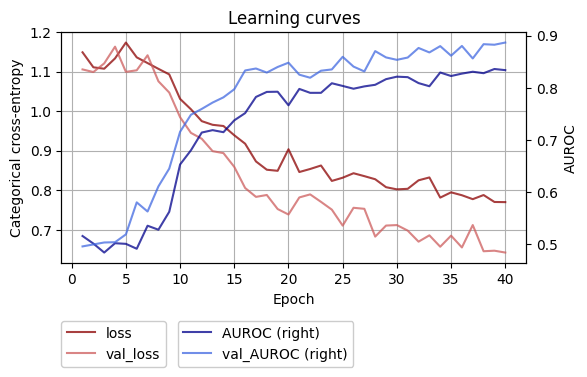

In [16]:
# Architecture V1.5
cnn1_5 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1_5")


# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 40
history1_5 = cnn1_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### +CNN1.6
Changing the optimizer to Adam improves the model, but after 15 epochs, the validation accuracy stabilizes, so we will add regularization L2 and decrease the epoch to 20.

Model: "CNN-V1.6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 18)      1368      
                                                                 
 activation (Activation)     (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        216

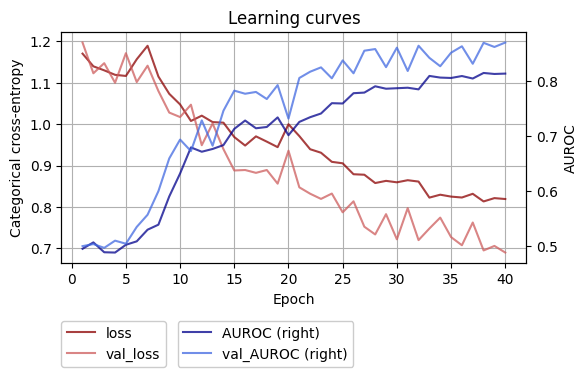

In [12]:
# Architecture V1.6
cnn1_6 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1.6")

# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1_6.build(input_shape)
# Check network
cnn1_6.summary()  

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1_6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 40
history1_6 = cnn1_6.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1_6.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

The LeNet model works very well with Adam optimizer. The main concern is overfitting, so we avoid implementing L2 regularization and stopping at the 20th epoch.

## CNN2 - AlexNet
Here we will aproach AlexNet method, by adding more layers (3 convolutional layers) and replacing the softmax in the convolution with the Relu that breaks up the linearity to increase the non-linearity of the images, employing the dropout rate regularization at starting point at 20%, to avoid overfitting and provide an efficient GPU implementation. We will strat with the same initial parameters, SGD optimizer, learning rate 0.001 and 40 epochs 

###CNN2.1

Epoch 1/40
17/17 [==============================] - 9s 180ms/step - loss: 1.1149 - categorical_accuracy: 0.3627 - AUROC: 0.5248 - val_loss: 1.0960 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5769
Epoch 2/40
17/17 [==============================] - 3s 98ms/step - loss: 1.0701 - categorical_accuracy: 0.4120 - AUROC: 0.6005 - val_loss: 1.0925 - val_categorical_accuracy: 0.4662 - val_AUROC: 0.6334
Epoch 3/40
17/17 [==============================] - 3s 98ms/step - loss: 1.0465 - categorical_accuracy: 0.4768 - AUROC: 0.6492 - val_loss: 1.0900 - val_categorical_accuracy: 0.3534 - val_AUROC: 0.6225
Epoch 4/40
17/17 [==============================] - 4s 178ms/step - loss: 1.0123 - categorical_accuracy: 0.5145 - AUROC: 0.6917 - val_loss: 1.0859 - val_categorical_accuracy: 0.5038 - val_AUROC: 0.6586
Epoch 5/40
17/17 [==============================] - 3s 101ms/step - loss: 0.9850 - categorical_accuracy: 0.5377 - AUROC: 0.7196 - val_loss: 1.0785 - val_categorical_accuracy: 0.5940 - val_AUROC:

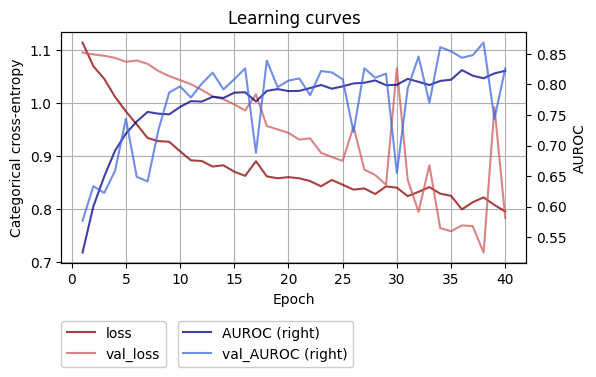

In [18]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.1
cnn2_1 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2.1")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 40
history2_1 = cnn2_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.2
We got a volatile model. Then, we will try the Adam optimizer, which works well in the LeNet Model.

Epoch 1/40
17/17 [==============================] - 8s 107ms/step - loss: 2.3968 - categorical_accuracy: 0.3540 - AUROC: 0.5034 - val_loss: 1.1009 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5118
Epoch 2/40
17/17 [==============================] - 3s 102ms/step - loss: 1.1000 - categorical_accuracy: 0.3375 - AUROC: 0.5079 - val_loss: 1.0990 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5006
Epoch 3/40
17/17 [==============================] - 3s 99ms/step - loss: 1.1011 - categorical_accuracy: 0.3453 - AUROC: 0.5090 - val_loss: 1.2188 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5047
Epoch 4/40
17/17 [==============================] - 3s 128ms/step - loss: 1.0999 - categorical_accuracy: 0.3578 - AUROC: 0.5266 - val_loss: 1.1069 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4879
Epoch 5/40
17/17 [==============================] - 3s 102ms/step - loss: 1.0715 - categorical_accuracy: 0.4023 - AUROC: 0.5917 - val_loss: 1.0714 - val_categorical_accuracy: 0.4887 - val_AUROC

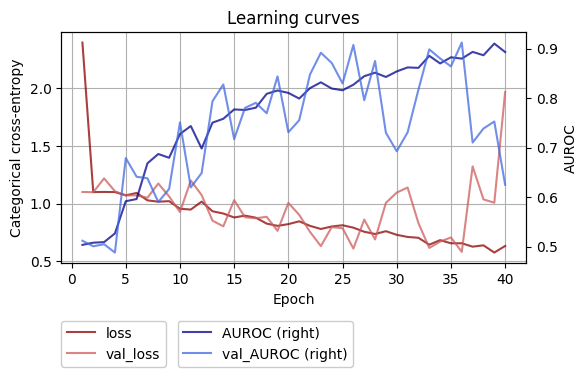

In [19]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.2
cnn2_2 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,      
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 40
history2_2 = cnn2_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.3
We will try with RMSprop Optimizer

Epoch 1/40
17/17 [==============================] - 7s 138ms/step - loss: 16.0421 - categorical_accuracy: 0.3530 - AUROC: 0.5170 - val_loss: 1.1011 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5345
Epoch 2/40
17/17 [==============================] - 3s 99ms/step - loss: 1.0966 - categorical_accuracy: 0.3714 - AUROC: 0.5502 - val_loss: 1.0974 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5191
Epoch 3/40
17/17 [==============================] - 4s 99ms/step - loss: 1.0608 - categorical_accuracy: 0.4603 - AUROC: 0.6233 - val_loss: 1.0877 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6067
Epoch 4/40
17/17 [==============================] - 3s 97ms/step - loss: 1.0360 - categorical_accuracy: 0.5000 - AUROC: 0.6685 - val_loss: 1.0403 - val_categorical_accuracy: 0.5489 - val_AUROC: 0.7232
Epoch 5/40
17/17 [==============================] - 3s 99ms/step - loss: 1.0059 - categorical_accuracy: 0.5213 - AUROC: 0.6959 - val_loss: 1.0692 - val_categorical_accuracy: 0.5113 - val_AUROC: 

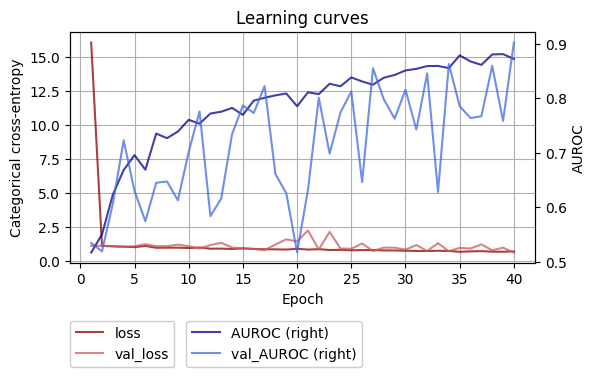

In [20]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V2.3
cnn2_3 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 40
history2_3 = cnn2_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.4
In the AlexNet method, the RMSprop Optimizer works better, but it can improve the unstable, we will increase the dropout rate to 30% and decrease the epoch to 30.

Epoch 1/30
17/17 [==============================] - 7s 182ms/step - loss: 23.2770 - categorical_accuracy: 0.3627 - AUROC: 0.5252 - val_loss: 1.0961 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5433
Epoch 2/30
17/17 [==============================] - 3s 101ms/step - loss: 1.0724 - categorical_accuracy: 0.4420 - AUROC: 0.6109 - val_loss: 1.1256 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5281
Epoch 3/30
17/17 [==============================] - 3s 97ms/step - loss: 1.0318 - categorical_accuracy: 0.4865 - AUROC: 0.6686 - val_loss: 2.1015 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5467
Epoch 4/30
17/17 [==============================] - 5s 187ms/step - loss: 1.1517 - categorical_accuracy: 0.4507 - AUROC: 0.6174 - val_loss: 1.0579 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6213
Epoch 5/30
17/17 [==============================] - 4s 102ms/step - loss: 1.0835 - categorical_accuracy: 0.4749 - AUROC: 0.6556 - val_loss: 1.1065 - val_categorical_accuracy: 0.2932 - val_AURO

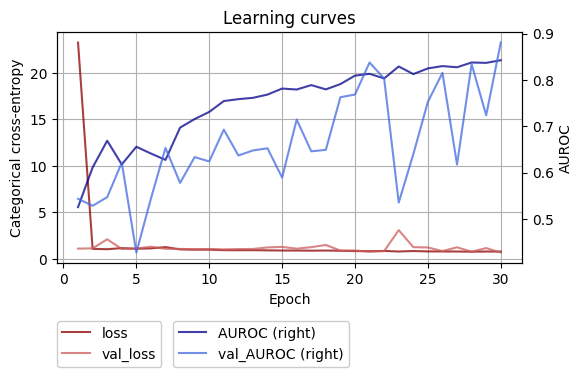

In [21]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V2.4
cnn2_4 = Sequential([# The input layer
                   layers.Input(input_shape),   
                   # Data augmentation
                   augmentation,   
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_4")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history2_4 = cnn2_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN2.5
Adding L2 Regularization

Epoch 1/30
17/17 [==============================] - 6s 140ms/step - loss: 19.2661 - categorical_accuracy: 0.3337 - AUROC: 0.4903 - val_loss: 1.1154 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5172
Epoch 2/30
17/17 [==============================] - 4s 112ms/step - loss: 1.0878 - categorical_accuracy: 0.3830 - AUROC: 0.5586 - val_loss: 1.1850 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4995
Epoch 3/30
17/17 [==============================] - 3s 98ms/step - loss: 1.1100 - categorical_accuracy: 0.3956 - AUROC: 0.5504 - val_loss: 1.5308 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5253
Epoch 4/30
17/17 [==============================] - 3s 98ms/step - loss: 1.1274 - categorical_accuracy: 0.4323 - AUROC: 0.6091 - val_loss: 1.0978 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5373
Epoch 5/30
17/17 [==============================] - 3s 99ms/step - loss: 1.0678 - categorical_accuracy: 0.4720 - AUROC: 0.6381 - val_loss: 1.0656 - val_categorical_accuracy: 0.4361 - val_AUROC:

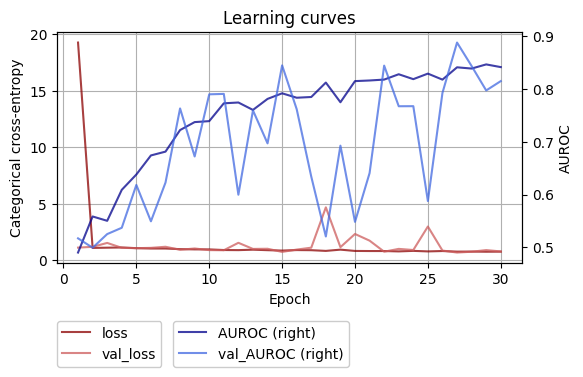

In [22]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V2.5
cnn2_5 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2_5")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history2_5 = cnn2_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN3 - AlexNet simplified
Our model continue overfiting, we additional way to avoid it is to reduce the complexity of the model, we can do this by removing the last layer.

### CNN3.1

Epoch 1/30
17/17 [==============================] - 7s 166ms/step - loss: 4.3897 - categorical_accuracy: 0.4149 - AUROC: 0.5697 - val_loss: 1.0768 - val_categorical_accuracy: 0.3609 - val_AUROC: 0.5962
Epoch 2/30
17/17 [==============================] - 3s 95ms/step - loss: 1.0683 - categorical_accuracy: 0.4874 - AUROC: 0.6523 - val_loss: 1.1433 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5535
Epoch 3/30
17/17 [==============================] - 4s 121ms/step - loss: 1.0363 - categorical_accuracy: 0.5106 - AUROC: 0.6738 - val_loss: 1.0847 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6184
Epoch 4/30
17/17 [==============================] - 3s 95ms/step - loss: 1.0161 - categorical_accuracy: 0.5261 - AUROC: 0.6989 - val_loss: 1.0839 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6113
Epoch 5/30
17/17 [==============================] - 3s 94ms/step - loss: 1.0529 - categorical_accuracy: 0.5280 - AUROC: 0.6932 - val_loss: 1.2673 - val_categorical_accuracy: 0.3383 - val_AUROC: 

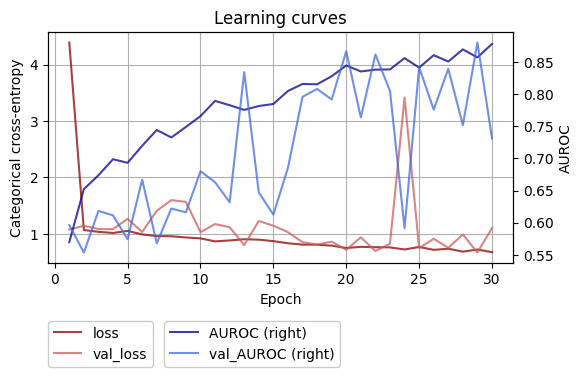

In [23]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.1
cnn3_1 = Sequential([# The input layer
                   layers.Input(input_shape),  
                   # Data augmentation
                   augmentation,    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3_1")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_1 = cnn3_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### +CNN3.2
Replaces the ``Rescaling`` layer with ``BatchNormalization``, allows to computing the z-scores from the pixel values.

Epoch 1/30
17/17 [==============================] - 6s 113ms/step - loss: 4.4713 - categorical_accuracy: 0.3627 - AUROC: 0.5252 - val_loss: 2.7678 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5269
Epoch 2/30
17/17 [==============================] - 5s 168ms/step - loss: 1.0711 - categorical_accuracy: 0.4507 - AUROC: 0.6297 - val_loss: 1.4887 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6190
Epoch 3/30
17/17 [==============================] - 3s 98ms/step - loss: 1.0664 - categorical_accuracy: 0.5203 - AUROC: 0.6754 - val_loss: 2.1842 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5543
Epoch 4/30
17/17 [==============================] - 3s 96ms/step - loss: 1.0442 - categorical_accuracy: 0.4787 - AUROC: 0.6607 - val_loss: 1.5637 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6240
Epoch 5/30
17/17 [==============================] - 3s 98ms/step - loss: 1.0479 - categorical_accuracy: 0.5222 - AUROC: 0.6828 - val_loss: 1.4745 - val_categorical_accuracy: 0.3985 - val_AUROC: 

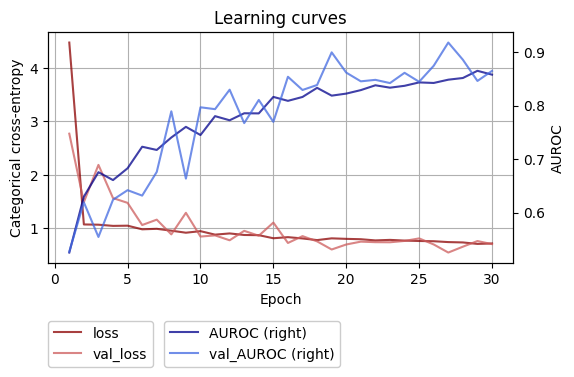

In [24]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.2
cnn3_2 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,     
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_2 = cnn3_2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.3
Dropout rate 20%, delete regularization L2 and 20 epoch.

Epoch 1/20
17/17 [==============================] - 7s 180ms/step - loss: 5.8659 - categorical_accuracy: 0.3839 - AUROC: 0.5496 - val_loss: 1.3889 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.6140
Epoch 2/20
17/17 [==============================] - 3s 97ms/step - loss: 1.0879 - categorical_accuracy: 0.4961 - AUROC: 0.6582 - val_loss: 1.4146 - val_categorical_accuracy: 0.4060 - val_AUROC: 0.6384
Epoch 3/20
17/17 [==============================] - 3s 100ms/step - loss: 1.0386 - categorical_accuracy: 0.5184 - AUROC: 0.6911 - val_loss: 1.8624 - val_categorical_accuracy: 0.4662 - val_AUROC: 0.6328
Epoch 4/20
17/17 [==============================] - 3s 119ms/step - loss: 1.0235 - categorical_accuracy: 0.5174 - AUROC: 0.6867 - val_loss: 1.3141 - val_categorical_accuracy: 0.4812 - val_AUROC: 0.6643
Epoch 5/20
17/17 [==============================] - 3s 102ms/step - loss: 0.9751 - categorical_accuracy: 0.5348 - AUROC: 0.7142 - val_loss: 1.0340 - val_categorical_accuracy: 0.5338 - val_AUROC

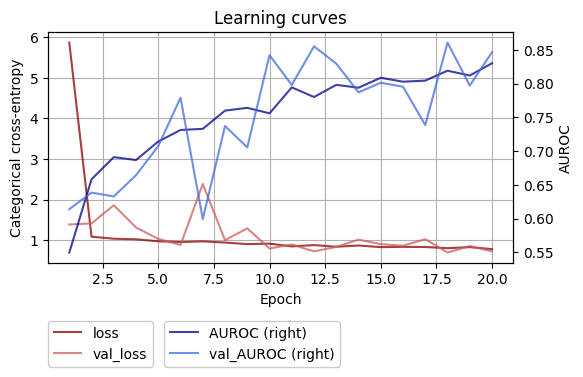

In [25]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V3.3
cnn3_3 = Sequential([# The input layer
                   layers.Input(input_shape), 
                   # Data augmentation
                   augmentation,      
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 20
history3_3 = cnn3_3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.4
20% dropout_rate, L2 regularization, 30 epochs

Epoch 1/30
17/17 [==============================] - 6s 135ms/step - loss: 5.4674 - categorical_accuracy: 0.3598 - AUROC: 0.5414 - val_loss: 2.1101 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4907
Epoch 2/30
17/17 [==============================] - 4s 113ms/step - loss: 1.0762 - categorical_accuracy: 0.4468 - AUROC: 0.6197 - val_loss: 2.1613 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5618
Epoch 3/30
17/17 [==============================] - 3s 99ms/step - loss: 1.0129 - categorical_accuracy: 0.5068 - AUROC: 0.6852 - val_loss: 1.0195 - val_categorical_accuracy: 0.5714 - val_AUROC: 0.7249
Epoch 4/30
17/17 [==============================] - 3s 101ms/step - loss: 1.0126 - categorical_accuracy: 0.5338 - AUROC: 0.7036 - val_loss: 2.0973 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5739
Epoch 5/30
17/17 [==============================] - 4s 168ms/step - loss: 0.9858 - categorical_accuracy: 0.5358 - AUROC: 0.7105 - val_loss: 1.8438 - val_categorical_accuracy: 0.3233 - val_AUROC

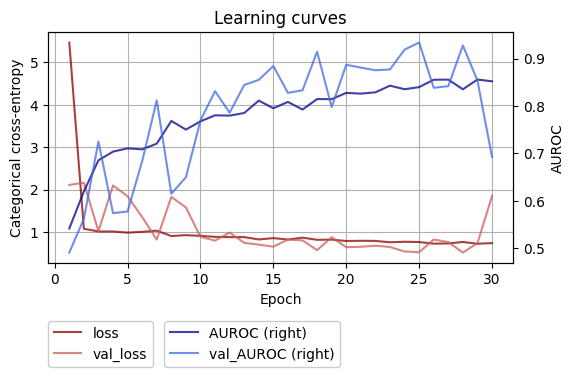

In [26]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.4
cnn3_4 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,       
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.4")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3_4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_4 = cnn3_4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

### CNN3.5
Learning rate 0.0001

Epoch 1/30
17/17 [==============================] - 6s 164ms/step - loss: 1.3947 - categorical_accuracy: 0.4516 - AUROC: 0.6132 - val_loss: 1.3765 - val_categorical_accuracy: 0.4060 - val_AUROC: 0.6046
Epoch 2/30
17/17 [==============================] - 3s 98ms/step - loss: 0.9670 - categorical_accuracy: 0.5426 - AUROC: 0.7283 - val_loss: 1.5396 - val_categorical_accuracy: 0.3459 - val_AUROC: 0.5764
Epoch 3/30
17/17 [==============================] - 3s 97ms/step - loss: 0.9707 - categorical_accuracy: 0.5348 - AUROC: 0.7193 - val_loss: 1.0564 - val_categorical_accuracy: 0.4211 - val_AUROC: 0.6636
Epoch 4/30
17/17 [==============================] - 3s 97ms/step - loss: 0.9391 - categorical_accuracy: 0.5706 - AUROC: 0.7473 - val_loss: 0.9260 - val_categorical_accuracy: 0.6391 - val_AUROC: 0.7764
Epoch 5/30
17/17 [==============================] - 3s 120ms/step - loss: 0.9166 - categorical_accuracy: 0.5899 - AUROC: 0.7577 - val_loss: 1.0417 - val_categorical_accuracy: 0.3459 - val_AUROC: 

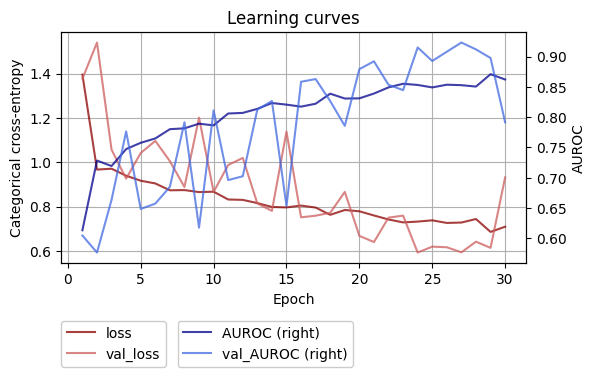

In [27]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.3
# Architecture V3.5
cnn3_5 = Sequential([# The input layer
                   layers.Input(input_shape),
                   # Data augmentation
                   augmentation,       
                   # Feature extraction
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer = regularizers.L2(l2=1e-4),
                                bias_regularizer = regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3.5")

# Compiles the model for training.
learning_rate = 0.0001  
cnn3_5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history3_5 = cnn3_5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3_5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## VGG

VGG (...). Defining a function to automatize neural architecture. Add a function block_vgg() function. The classification head is regularized/simplified with the GlobalMaxPooling2D() layer. To resemble the VGG16 variant, use vgg_blocks = ((2, 64, False), (2, 128, False), (2, 256, True), (2, 512, True), (2, 512, True)).

In [14]:
def block_vgg(conv_layers, filters, conv1x1=True, batch_norm=True, seed=0):
    block = Sequential()
    for l in range(conv_layers + conv1x1):
        block.add(layers.Conv2D(filters, 
                                kernel_size=1 if l==conv_layers else 3, padding="same",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)))
        if batch_norm:
            block.add(layers.BatchNormalization())                         
        block.add(layers.Activation("relu"))
    
    block.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return block

compile the model, train it, creates a pandas.DataFrame from history dictionary and plots the learning curves.

### +VGG1.1

Model: "VGG-V1.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_16 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 sequential (Sequential)     (64, 64, 64, 32)          10400     
                                                                 
 sequential_1 (Sequential)   (64, 32, 32, 64)          55936     
                                                                 
 sequential_2 (Sequential)   (64, 16, 16, 128)         239488    
                                                                 
 global_max_pooling2d (Globa  (64, 128)                0         
 lMaxPooling2D)                                                  
                                                                 
 dropout_10 (Dropout)        (64, 128)                 0  

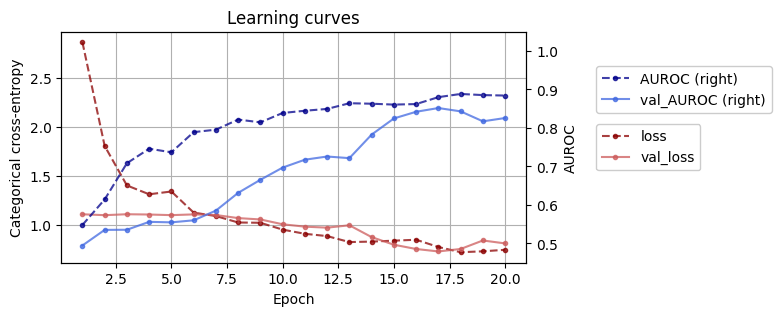

In [31]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_1 = ((2, 32, False), (2, 64, False), (2, 128, True)) 
# Create CNN
vgg1_1 = Sequential(layers.BatchNormalization(), name="VGG-V1.1")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_1:
    vgg1_1.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_1.add(layers.GlobalMaxPooling2D())
vgg1_1.add(layers.Dropout(0.2))
vgg1_1.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_1.build(input_shape)
# Check model
vgg1_1.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_1.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 20
    history1_1 = vgg1_1.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. Plots the learning curves
secondary_y = ["AUROC", "val_AUROC"]    # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
#ax.right_ax.legend(loc=(0.25, -0.65), framealpha=1.0)
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
#ax.legend(loc=(0, -0.65), framealpha=1.0)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()

### VGG1.2
Adding more feature detectors

Model: "VGG-V1_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 sequential (Sequential)     (64, 64, 64, 64)          39232     
                                                                 
 sequential_1 (Sequential)   (64, 32, 32, 128)         222464    
                                                                 
 sequential_2 (Sequential)   (64, 16, 16, 256)         954112    
                                                                 
 global_max_pooling2d (Globa  (64, 256)                0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (64, 256)                 0  

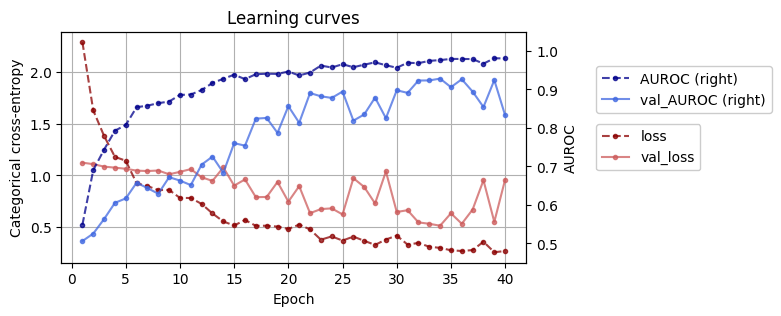

In [15]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_2 = ((2, 64, False), (2, 128, False), (2, 256, True)) 
# Create CNN
vgg1_2 = Sequential(layers.BatchNormalization(), name="VGG-V1_2")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_2:
    vgg1_2.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_2.add(layers.GlobalMaxPooling2D())
vgg1_2.add(layers.Dropout(0.2))
vgg1_2.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_2.build(input_shape)
# Check model
vgg1_2.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_2.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 40
    history1_2 = vgg1_2.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. Plots the learning curves
secondary_y = ["AUROC", "val_AUROC"] #["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
#ax.right_ax.legend(loc=(0.25, -0.65), framealpha=1.0)
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
#ax.legend(loc=(0, -0.65), framealpha=1.0)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()

### VGG1.3
Add more ...

Model: "VGG-V1_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 sequential_3 (Sequential)   (64, 64, 64, 32)          10400     
                                                                 
 sequential_4 (Sequential)   (64, 32, 32, 64)          55936     
                                                                 
 sequential_5 (Sequential)   (64, 16, 16, 128)         239488    
                                                                 
 sequential_6 (Sequential)   (64, 8, 8, 256)           954112    
                                                                 
 global_max_pooling2d_1 (Glo  (64, 256)                0         
 balMaxPooling2D)                                         

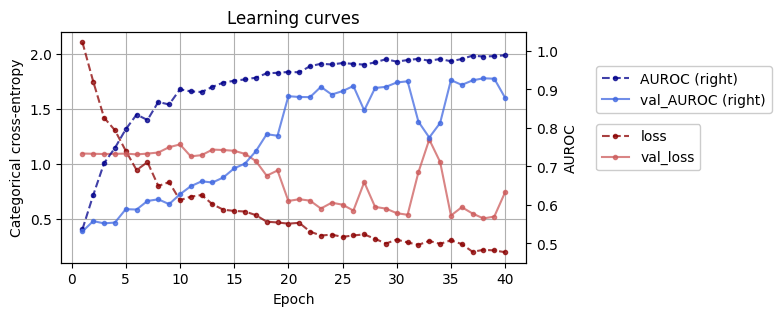

In [16]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_3 = ((2, 32, False), (2, 64, False), (2, 128, True), (2, 256, True)) 
# Create CNN
vgg1_3 = Sequential(layers.BatchNormalization(), name="VGG-V1_3")
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_3:
    vgg1_3.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
# Define the classification head
vgg1_3.add(layers.GlobalMaxPooling2D())
vgg1_3.add(layers.Dropout(0.2))
vgg1_3.add(layers.Dense(units=3, activation="softmax",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))
# Build the DAG 
vgg1_3.build(input_shape)
# Check model
vgg1_3.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    vgg1_3.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. Trains the model
    epochs = 40
    history1_3 = vgg1_3.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=2)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. Creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history1_3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. Plots the learning curves
secondary_y = ["AUROC", "val_AUROC"] #["accuracy", "val_accuracy"]  
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                          alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
#ax.right_ax.legend(loc=(0.25, -0.65), framealpha=1.0)
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
#ax.legend(loc=(0, -0.65), framealpha=1.0)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()

## Functional AI (standard)

## CNN4.1

In [48]:
# 1. create an input node using the tf.keras.Input class (which is different from tf.keras.layers.Input). 
# The input node instantiates a symbolic tensor-like object that allows building a Keras model just by knowing the inputs and outputs of the model
inputs = layers.Input(shape=input_shape[1:])  
# 2. compute the z-scores from the batch
x = layers.BatchNormalization()(inputs)
# 3. specify the convolutional backbone for learning representations
x = layers.Conv2D(filters=32, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x) 
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, 
                  kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# 4. perform global pooling to reduce a HxWxC cuboid of features into a C-dimensional vector
x = layers.GlobalMaxPooling2D()(x)
# 5. specify the classifier
y_pred = layers.Dense(units=3, activation="softmax", 
                      kernel_initializer=initializers.GlorotNormal(seed=seed))(x)
# 6. create final model from inputs and outputs using the tf.keras.Model class
cnn4_1 = Model(inputs, y_pred)
# Check network
cnn4_1.summary()  # alternatively use tf.keras.utils.plot_model(cnn1, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 batch_normalization_62 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_91 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_63 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 activation_84 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 63, 63, 32)       0     

Epoch 1/30
17/17 [==============================] - 6s 155ms/step - loss: 2.0288 - categorical_accuracy: 0.3985 - AUROC: 0.5759 - val_loss: 2.0545 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5922
Epoch 2/30
17/17 [==============================] - 3s 107ms/step - loss: 0.9506 - categorical_accuracy: 0.5870 - AUROC: 0.7600 - val_loss: 1.8435 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6000
Epoch 3/30
17/17 [==============================] - 3s 102ms/step - loss: 0.7752 - categorical_accuracy: 0.6712 - AUROC: 0.8378 - val_loss: 1.5861 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6382
Epoch 4/30
17/17 [==============================] - 4s 153ms/step - loss: 0.6805 - categorical_accuracy: 0.7137 - AUROC: 0.8755 - val_loss: 1.8708 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6503
Epoch 5/30
17/17 [==============================] - 3s 105ms/step - loss: 0.6037 - categorical_accuracy: 0.7708 - AUROC: 0.9040 - val_loss: 0.9223 - val_categorical_accuracy: 0.4887 - val_AURO

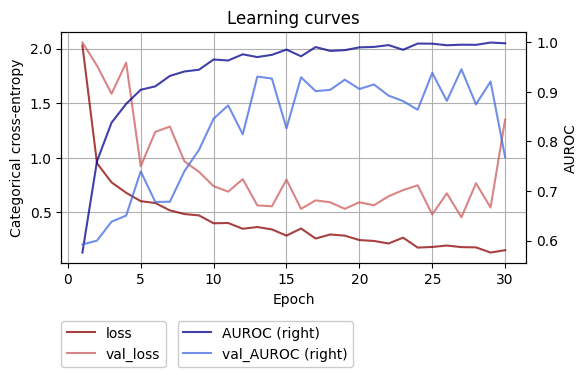

In [49]:
# Compiles the model for training.
learning_rate = 0.001  
cnn4_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history4_1 = cnn4_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history4_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## Functional (object-oriented)

## +CNN5.1

In [51]:
class CustomCNN(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Z-scores 
        self.zscores = layers.BatchNormalization()
        # Convolutional layers (with learnable parameters)
        self.conv32 = layers.Conv2D(filters=32, kernel_size=3, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv64 = layers.Conv2D(filters=64, kernel_size=3, 
                                    kernel_initializer=initializers.GlorotNormal(seed=seed))        
        # Batch normalization layers (with learnable parameters)
        self.bn32 = layers.BatchNormalization()                          
        self.bn64 = layers.BatchNormalization()
        # Classifier's head
        self.dense1 = layers.Dense(units=3, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers (define only once)
        self.relu = layers.Activation("relu")
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        # Orderly flows the inputs through the network's components
        x = self.zscores(inputs)
        x = self.conv32(x)
        x = self.bn32(x)
        x = self.relu(x)
        x = self.maxpool2x2(x)
        x = self.conv64(x)
        x = self.bn64(x)
        x = self.relu(x)
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of the CustomCNN class
cnn5_1 = CustomCNN(seed=seed)
# Builds the DAG 
cnn5_1.build(input_shape)
# Check the network
cnn5_1.summary()

Model: "custom_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_65 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_93 (Conv2D)          multiple                  896       
                                                                 
 conv2d_94 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_66 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 batch_normalization_67 (Bat  multiple                 256       
 chNormalization)                                                
                                                      

Epoch 1/30
17/17 [==============================] - 6s 136ms/step - loss: 1.9689 - categorical_accuracy: 0.4536 - AUROC: 0.6064 - val_loss: 2.4887 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5933
Epoch 2/30
17/17 [==============================] - 3s 130ms/step - loss: 0.8967 - categorical_accuracy: 0.6170 - AUROC: 0.7869 - val_loss: 3.3036 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5702
Epoch 3/30
17/17 [==============================] - 4s 122ms/step - loss: 0.7476 - categorical_accuracy: 0.6876 - AUROC: 0.8499 - val_loss: 2.3609 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6310
Epoch 4/30
17/17 [==============================] - 3s 102ms/step - loss: 0.6459 - categorical_accuracy: 0.7389 - AUROC: 0.8889 - val_loss: 1.7929 - val_categorical_accuracy: 0.3459 - val_AUROC: 0.6300
Epoch 5/30
17/17 [==============================] - 3s 102ms/step - loss: 0.6089 - categorical_accuracy: 0.7563 - AUROC: 0.9018 - val_loss: 1.4963 - val_categorical_accuracy: 0.3684 - val_AURO

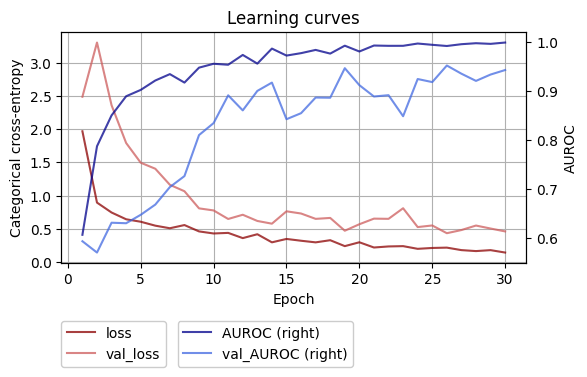

In [52]:
# Compiles the model for training.
learning_rate = 0.001  
cnn5_1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 30
history5_1 = cnn5_1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history5_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("AUROC")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## ResNet using the Functional API - Standard residual block

In [19]:
class ResidualBlock(tf.keras.Model):  
    def __init__(self, in_filters, expand=1, downsample=False, seed=0):
        super().__init__()       
        self.expand = expand
        self.downsample = downsample
        self.conv1 = layers.Conv2D(in_filters, kernel_size=3, padding="same",
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv2 = layers.Conv2D(in_filters*self.expand, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        #if self.downsample:
        #    self.conv1x1 = layers.Conv2D(filters, kernel_size=1, strides=2,
        #                                 kernel_initializer=initializers.GlorotNormal(seed=seed))
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)           
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)
        return x   
 

## ResNet using the Functional API - Bottleneck residual block

In [20]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x        

## ResNet using the Functional API - CustomResNet

## +CNN6.1

In [21]:
class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # # Z-scores 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)   
        # etc.
        # Classifier
        self.dense1 = layers.Dense(units=3, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn6_1 = CustomResNet(seed=seed)
# Builds the DAG 
cnn6_1.build(input_shape)
# Check the network
cnn6_1.summary()
# Set control flag to True
train = True

Model: "custom_res_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_25 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block (Bottlenec  multiple                 58752     
 kBlock)                                                         
                                                                 
 bottleneck_block_1 (Bottlen  multiple                 96384     
 eckBlock)                                        

Epoch 1/40
17/17 [==============================] - 7s 141ms/step - loss: 1.3597 - accuracy: 0.6422 - AUROC: 0.5706 - val_loss: 1.2709 - val_accuracy: 0.4937 - val_AUROC: 0.5184
Epoch 2/40
17/17 [==============================] - 4s 174ms/step - loss: 0.9491 - accuracy: 0.7044 - AUROC: 0.7150 - val_loss: 1.0982 - val_accuracy: 0.4987 - val_AUROC: 0.5603
Epoch 3/40
17/17 [==============================] - 3s 98ms/step - loss: 0.7997 - accuracy: 0.7411 - AUROC: 0.7871 - val_loss: 1.1410 - val_accuracy: 0.5464 - val_AUROC: 0.5656
Epoch 4/40
17/17 [==============================] - 3s 98ms/step - loss: 0.7063 - accuracy: 0.7801 - AUROC: 0.8259 - val_loss: 1.0837 - val_accuracy: 0.5664 - val_AUROC: 0.5881
Epoch 5/40
17/17 [==============================] - 3s 96ms/step - loss: 0.6351 - accuracy: 0.7950 - AUROC: 0.8583 - val_loss: 1.1126 - val_accuracy: 0.5439 - val_AUROC: 0.5774
Epoch 6/40
17/17 [==============================] - 4s 157ms/step - loss: 0.5935 - accuracy: 0.8040 - AUROC: 0.87

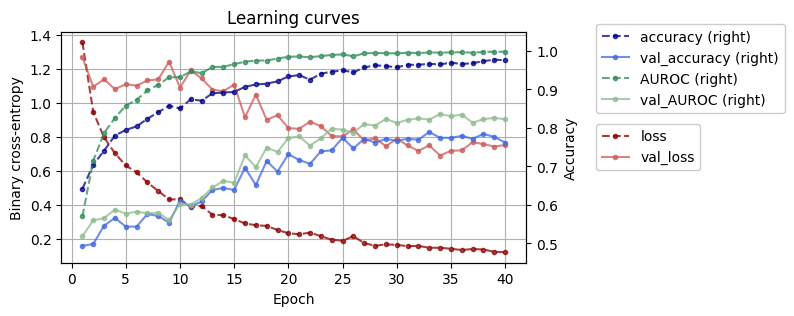

In [23]:
if train:
    # Measure the start time
    start = time.time()
    # 1. compiles the model
    learning_rate = 0.001
    cnn6_1.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    # 2. trains the model
    epochs = 40
    history6_1 = cnn6_1.fit(ds_train, validation_data=ds_validation, epochs=epochs, verbose=1)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False
# 3. creates a pandas.DataFrame from history dictionary
df_hist = pd.DataFrame.from_dict(history6_1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# 4. plots the learning curves
secondary_y = ["accuracy", "val_accuracy", "AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                         alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()